# *Statistics coded:* Visualisation of excess mortality over Europe in 2020 using _Eurostat_ data

Prepared by [**J.Grazzini**](mailto:jacopo.grazzini@ec.europa.eu) ([**Eurostat**](https://ec.europa.eu/eurostat), Methodology & Innnovation unit).

<div class="alert alert-block alert-info">
<h4>Table of contents</h4>
<ul>    
    <li><a href="#Introduction">Introduction</a>.</li>
    <li><a href="#Settings">Settings</a>.</li>
    <li><a href="#Data-ingestion">Data ingestion</a>.</li>
    <li><a href="#Data-preparation">Data preparation</a>.</li>
    <li><a href="#Data-exploration">Data exploration</a>.</li>
    <li><a href="#death-representation">Excessive death representation</a>.</li>
    <li><a href="#spatial-visualisations">Spatio-temporal visualisations</a>.</li>
</ul>    
</div>

## Introduction<a id="Introduction"></a>

The purpose of this notebook is to dynamically generate maps of weekly excess mortality over Europe NUTS2 or NUTS3 regions, depending on their availability. It reproduces some of the figures of the *Statistics Explained* article on [**weekly death statistics**](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics&stable).  

### Data sources

* The data analysed in this notebook are fetched from [_Eurostat_ online database](https://ec.europa.eu/eurostat/data/database) on the date of the last run.  
  * _Eurostat_ data on _"Deaths by age group, sex, week and NUTS 3 region"_ [demo_r_mweek3](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mweek3&lang=en),
  * _Eurostat_ data on _"Deaths by week and sex"_ [demo_r_mwk_ts](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=demo_r_mwk_ts&lang=en) (not used here),
  * _Eurostat_ geographical data on regional units NUTS 2016 (see [GISCO website](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)).
* Data are actually fetched from _Eurostat_ [bulk download facility](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data) (*i.e.*, full/bulk datasets in _TSV_ format) instead of connecting to [_Eurostat_ REST API](https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/rest-request) (*i.e.*, subdatasets in _JSON_ format). 


### Main outcomes

We provide here with some quick and dirty material to fetch the data from the provider and compute basic descriptive statistics (*e.g.*, an excess indice/rate).

We compute the spatial (continental Europe at NUTS level 3) and temporal (over a short time period, from 24/02/20 to 26/04/20) distribution of excess mortality, and visualise the figures as: 
* [static map](#MapAggregated) over the aggregate period,
* [individual statics maps](#Maps) for every single week in the considered period,
* ibid, but [overlayed dynamic maps](#MapsOverlay) are displayed,  
* ibid, a [time slider of the static maps](#MapsSlider) is made available.

<div class="alert alert-block alert-info">
   
<h3> History / versions</h3>
<ul>    
    <li>This notebook was created on <b>13/05/20</b>.</li>
    <li>On 24/06/20, Eurostat released a press article on <a href"https://ec.europa.eu/eurostat/web/products-eurostat-news/-/DDN-20200624-1?inheritRedirect=true&redirect=%2Feurostat%2F">2020 data on weekly deaths</a>.</li>
    <li>On 26/06/20, Eurostat released a <i>Statistics Explained<i> article on <a href"https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics">weekly death statistics</a>.</li>
    <li><b>Update of 28/06/20</b>: while the initial results reported excess death rates ($100\times\frac{D - D_{\text{base}}}{D_{\text{base}}}$), the calculations have been updated so as to provide now "base-100" excess death indices ($100\times\frac{D}{D_{\text{base}}}$) similar to what is presented in the <i>Statistics Explained</i> article mentioned above.</li>
    <li><b>Update of 1/07/20</b>: comments from the <a href"https://ec.europa.eu/eurostat/web/gisco">Eurostat GISCO</a> team regarding map visualisation were integrated onto the notebook.</li> 
    <li><b>Update of 1/04/21</b>: as the size of the bulk datasets is increasingly growing (on a weekly basis), it became unpractical (owing to memory limitations) to load the entire datasets in the notebook. Therefore, some workarounds have been introduced, <i>e.g.</i> through further parameterisation of the <code>pandas.read_csv</code> function <a href="#read_csv">cell #17</a>). However, to circumvent this issue, the ideal approach / best practice shall consist instead in fetching the desired (selected) data directly from <a href="https://ec.europa.eu/eurostat/web/json-and-unicode-web-services/getting-started/rest-request"><i>Eurostat</i> REST API</a>.</li>
</ul>
</div>    

  
<div class="alert alert-block alert-warning">
    
<h3> Disclaimer</h3>
    
Regarding the material displayed on maps in this notebook, the designations employed and the presentations adopted do not imply the expression of any opinion whatsoever on the part of the European Union concerning the legal status of any country, territory, city or area or of its authorities, or concerning the delimitation of its frontiers or boundaries. <b>Representations are approximations</b>.
</div>    

## Settings<a id="Settings"></a>

In [1]:
from datetime import datetime
print("Last update/running of this notebook: \033[1m%s\033[0m" % datetime.today())

Last update/running of this notebook: 2021-04-23 15:14:33.678106


In [2]:
_THISDIR_ = !pwd
print('Current working directory: %s' % _THISDIR_)

Current working directory: ['/Users/gjacopo/DevOps/mortality-viz']


Let's import all we need, starting with the basic packages:

In [3]:
import requests
import io, os, re, sys
import warnings
import copy, functools
import zipfile

as well as common data handling mocdules `pandas` and `numpy`:

In [4]:
import json

import pandas as pd
pd.set_option('mode.chained_assignment', None) # ignore SettingWithCopyWarning
import numpy as np

We also perform all geometric/set operations of vector layers using the `geopandas` package:

In [5]:
try:
    import geopandas as gpd
except ImportError:
    try:
        !{sys.executable} -m pip install geopandas
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        import geopandas as gpd
finally:
    warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

try:
    from shapely import geometry
except ImportError:
    try:
        !{sys.executable} -m pip install shapely
    except:
        print("! Package geopandas not installed !")
    else:
        print("! Package geopandas installed on-the-fly !")
        from shapely import geometry

For visualisation purpose, the package `matplotlib` is used:

In [6]:
try:
    import matplotlib
except ImportError:
    raise IOError("Guess what: you're doomed...")
else:
    import matplotlib.pyplot as mplt
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter, MaxNLocator, IndexLocator
finally:
    _FIGSIZE_, _DPI_ = (7,4), 140 # just some default display size/resolution inside this notebook...
%matplotlib inline

Last, for interactive mapping, we use `folium` while `branca` is used for building a colormpa similar to that of the *Statistics Explained* article mentioned above:

In [7]:
try:
    import folium
except ImportError:
    try:
        !{sys.executable} -m pip install folium
    except:
        print("! Package folium not installed !")
    else:
        print("! Package folium installed on-the-fly !")
        import folium
finally:
    from folium import plugins as foliump

try:
    import branca
except ImportError:
    try:
        !{sys.executable} -m pip install branca
    except:
        print("! Package branca not installed !")
    else:
        print("! Package branca installed on-the-fly !")
finally:
    import branca.colormap as bcm

## (Dirty) data ingestion<a id="Data-ingestion"></a>

### Mortality data

Data on death figures will be fetched from [Eurostat bulk website](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data). The link to the data source in TSV format is : https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz. 

In [8]:
BULK_DOMAIN = 'https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1'
DEATH_FILE = 'demo_r_mweek3'
DEATH_FMT = 'tsv' # or xml...

death_url = '{}&file=data%2F{}.{}.gz'.format(BULK_DOMAIN, DEATH_FILE, DEATH_FMT)

print("URL for death data: \033[1m%s\033[0m" % death_url)

URL for death data: https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz


In [9]:
death_source = '%s.%s.gz' % (DEATH_FILE, DEATH_FMT)

try : 
    dest = os.path.join(_THISDIR_[0], ('.').join(death_source.split('.')[:-1]))
    assert os.path.exists(dest)
except:
    try:
        !wget -O $death_source "$death_url"
        !gunzip -f $death_source # note: we could use compression='gzip' in read_csv instead
    except:
        raise IOError("Error fetching & unzipping the data...")
    else:
        print('Data is loaded on disk in \033[1m%s\033[0m' % dest)
else:
    print('Data alredy on disk in \033[1m%s\033[0m' % dest)
finally:
    death_ext = DEATH_FMT
    death_source = dest

--2021-04-23 15:14:39--  https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fdemo_r_mweek3.tsv.gz
Resolving ec.europa.eu (ec.europa.eu)... 2a01:7080:24:100::666:30, 2a01:7080:14:100::666:30, 147.67.34.30, ...
Connecting to ec.europa.eu (ec.europa.eu)|2a01:7080:24:100::666:30|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 33896806 (32M) [application/octet-stream]
Saving to: ‘demo_r_mweek3.tsv.gz’

demo_r_mweek3.tsv.g 100%[===================>]  32.33M  3.20MB/s    in 9.4s    

2021-04-23 15:14:49 (3.44 MB/s) - ‘demo_r_mweek3.tsv.gz’ saved [33896806/33896806]

Data is loaded on disk in /Users/gjacopo/DevOps/mortality-viz/demo_r_mweek3.tsv


### Geographical data

Ibid with the geographical resources that you can retrieve from GISCO API, *e.g.* [https://gisco-services.ec.europa.eu/distribution/v2/](https://gisco-services.ec.europa.eu/distribution/v2/). 

We first select the projection that will be used in this exercise. For visualisation purpose, we select the common lat/lon coordinate system (WGS84, or [`EPSG:4326`](https://epsg.io/4326)) as the reference system:

In [10]:
PROJ = 'EPSG:4326'

We can then integrate the NUTS data:

In [11]:
GISCO_DOMAIN = 'https://gisco-services.ec.europa.eu/distribution/v2/'
NUTS_DOMAIN = 'nuts'

NUTS_YEAR = 2021
NUTS_RES = 20 # 60
NUTS_PROJ = PROJ.split(':')[-1] 
NUTS_FMT = 'geojson' # 'topojson'

nuts_template = 'NUTS_RG_%sM_%s_%s_LEVL_%%s.%s' % (NUTS_RES, NUTS_YEAR, NUTS_PROJ, NUTS_FMT) 
nuts_url = '%s/%s/%s' %  (GISCO_DOMAIN, NUTS_DOMAIN, NUTS_FMT)

#https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_20M_2021_3857_LEVL_1.geojson
#    'NUTS_RG_%sM_%s_3035_LEVL_%s.%s'

print("Generic URL for NUTS data: \033[1m%s/%s\033[0m (where '%%s' represents a level)" 
      % (nuts_url, nuts_template))

Generic URL for NUTS data: https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_%s.geojson (where '%s' represents a level)


In [12]:
LEVELS = [0,1,2,3]

nuts_files = dict.fromkeys(LEVELS)
nuts_ext = NUTS_FMT

for level in LEVELS:
    nuts_file = nuts_template % level
    nuts_source = '%s/%s' % (nuts_url,nuts_file)
    try : 
        dest = os.path.join(_THISDIR_[0], nuts_file)
        assert os.path.exists(dest)
    except:
        try:
            !wget -O $dest "$nuts_source"
            #!mkdir $nuts_dir
            #!unzip -u -d $nuts_dir $nuts_source        
        except:
            raise IOError("Error fetching the data...")
        else:
            print('Data loaded on disk in directory: \033[1m%s\033[0m' % dest)
    else:
        print('Data already loaded on disk in directory: \033[1m%s\033[0m' % dest)
    finally:
        nuts_files.update({level: nuts_file}) # dest

--2021-04-23 15:14:55--  https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_0.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.93.170
Connecting to gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)|40.113.93.170|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162843 (159K)
Saving to: ‘/Users/gjacopo/DevOps/mortality-viz/NUTS_RG_20M_2021_4326_LEVL_0.geojson’

/Users/gjacopo/DevO 100%[===================>] 159.03K  --.-KB/s    in 0.1s    

2021-04-23 15:14:56 (1.43 MB/s) - ‘/Users/gjacopo/DevOps/mortality-viz/NUTS_RG_20M_2021_4326_LEVL_0.geojson’ saved [162843/162843]

Data loaded on disk in directory: /Users/gjacopo/DevOps/mortality-viz/NUTS_RG_20M_2021_4326_LEVL_0.geojson
--2021-04-23 15:14:56--  https://gisco-services.ec.europa.eu/distribution/v2//nuts/geojson/NUTS_RG_20M_2021_4326_LEVL_1.geojson
Resolving gisco-services.ec.europa.eu (gisco-services.ec.europa.eu)... 40.113.

Fetch the URL to get the response:

## Data preparation<a id="Data-preparation"></a>

### NUTS data selection

We first explore the [NUTS data](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts). Actually we consider NUTS region boundaries at all levels (`LEVELS`), from 0 to 3, since some data are available at country level. Hence we 'store' one vector dataset per NUTS level (`nuts_data`): 

In [13]:
DRIVERS = {'geojson': 'GeoJSON',
          'shp': 'ESRI Shapefile'}

nuts_data = dict.fromkeys(LEVELS)
[nuts_data.update({l: gpd.read_file(os.path.join(_THISDIR_[0], nuts_files[l]), 
                                    driver=DRIVERS[NUTS_FMT])}) 
 for l in LEVELS]

print("Geographical datasets: \033[1m%s\033[0m loaded" % list(nuts_files.values()))
print("Projection: \033[1m%s\033[0m" % nuts_data[LEVELS[0]].crs)

nuts_data[LEVELS[1]].head(5)

Geographical datasets: ['NUTS_RG_20M_2021_4326_LEVL_0.geojson', 'NUTS_RG_20M_2021_4326_LEVL_1.geojson', 'NUTS_RG_20M_2021_4326_LEVL_2.geojson', 'NUTS_RG_20M_2021_4326_LEVL_3.geojson'] loaded
Projection: epsg:4326


id NUTS_ID  LEVL_CODE CNTR_CODE  \
0  BE1     BE1          1        BE   
1  BE2     BE2          1        BE   
2  BE3     BE3          1        BE   
3  BG3     BG3          1        BG   
4  BG4     BG4          1        BG   

                                           NAME_LATN  \
0  Région de Bruxelles-Capitale/Brussels Hoofdste...   
1                                      Vlaams Gewest   
2                                    Région wallonne   
3                    Severna i Yugoiztochna Bulgaria   
4           Yugozapadna i Yuzhna tsentralna Bulgaria   

                                           NUTS_NAME  MOUNT_TYPE URBN_TYPE  \
0  Région de Bruxelles-Capitale/Brussels Hoofdste...           0      None   
1                                      Vlaams Gewest           0      None   
2                                    Région wallonne           0      None   
3                      Северна и Югоизточна България           0      None   
4               Югозападна и Южна централна България           0      None   

  COAST_TYPE  FID                                           geometry  
0       None  BE1  POLYGON ((4.28308 50.81361, 4.28883 50.89180, ...  
1       None  BE2  MULTIPOLYGON (((4.75993 51.50246, 4.86400 51.4...  
2       None  BE3  MULTIPOLYGON (((5.68200 50.75745, 5.81905 50.7...  
3       None  BG3  POLYGON ((22.99717 43.80787, 23.40948 43.84985...  
4       None  BG4  POLYGON ((23.00621 43.19288, 23.17950 43.11498...

Let's have a "quick" render of the NUTS data: 

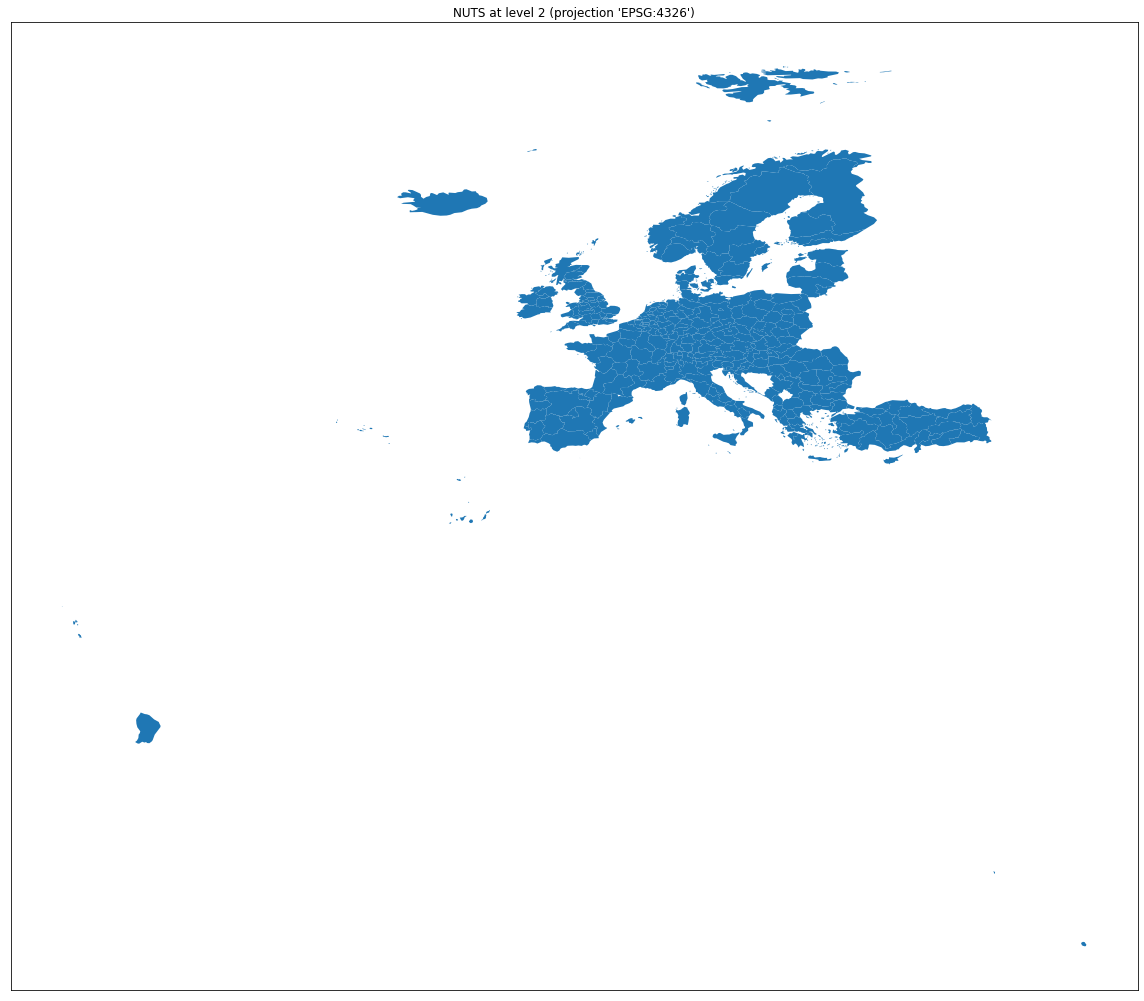

In [14]:
level = LEVELS[2]

f, ax = mplt.subplots(1, figsize=(16, 16))
nuts_data[level].plot(ax=ax)
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title("NUTS at level %s (projection 'EPSG:%s')" % (level,NUTS_PROJ)) 
f.tight_layout()
mplt.show()

### Mortality data filtering

We first retrieve the columns of the datasets which will inform us about the timeline of the collected data, *e.g.* the number of weekly acquisitions available (`WEEK_COLS`), the temporal coverage (`YEARS`), as well as the latest period covered (`YCUR`): 

In [15]:
header = pd.read_csv(death_source, sep = '\t', encoding = 'latin1', nrows = 1)

WEEK_COLS = [col for col in header.columns if re.search('W',col) is not None]
print('Number of weekly observations: %s' % len(WEEK_COLS))

YEARS = list(set([int(col.split('W')[0]) for col in WEEK_COLS]))
print("Years present in the dataset: \033[1m%s\033[0m" % YEARS)

YCUR = max(YEARS)
print("Latest available year: \033[1m%s\033[0m" % YCUR)

Number of weekly observations: 1132
Years present in the dataset: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Latest available year: 2021


At this stage, we shall select the start (`YSTART`) and end (`YEND`) dates for the study. This can obviously be adapted so as to align with the reference *Statistics Explained* article:

In [16]:
YSTART = 2016
YEND = 2020 # YCUR ?

try:
    assert YSTART in YEARS
except:
    raise IOError("Select another start year in \033[1m%s\033[0m" % YEARS)
else:
    CYEARS, RYEARS = range(YSTART, YEND), range(YSTART, YEND+1)
    
try:
    assert YCUR >= YEND
except:
    raise IOError("Select another end year in \033[1m%s\033[0m" % YEARS)

Following, we ingest the subset (`death_data`) of mortality data that correspond to the specific period / years we want to analyse. We know already that we will not be using all the data: actually, all data collected prior to `YSTART` period can be discarded. This prior (coarse) filtering will also reduce the risks of running out of memory:<a id="read_csv"></a>:

In [17]:
NCOLS = 52 * (YCUR - YSTART +1) + 1 # that should be refined to keep only the first column then all relevant years...
death_data = pd.read_csv(death_source, sep = '\t', encoding = 'latin1', 
                         dtype = str, usecols = range(0, NCOLS)) 
                        # keep_default_na = True, na_values = [':', ': ', ' :', ' : ']
                        # low_memory = True, engine = 'c', compression='gzip'

print('Dimensions of the table: %s' % list(death_data.shape))
death_data.head(5)

Dimensions of the table: [88863, 313]


unit,sex,age,geo\time 2021W99  2021W14  2021W13  2021W12  2021W11  2021W10   \
0         NR,F,TOTAL,AL       :        :        :        :        :        :    
1        NR,F,TOTAL,AL0       :        :        :        :        :        :    
2       NR,F,TOTAL,AL01       :        :        :        :        :        :    
3      NR,F,TOTAL,AL011       :        :        :        :        :        :    
4      NR,F,TOTAL,AL012       :        :        :        :        :        :    

  2021W09  2021W08  2021W07   ... 2015W33  2015W32  2015W31  2015W30   \
0       :        :        :   ...     168      162      210      308    
1       :        :        :   ...     167      162      210      308    
2       :        :        :   ...      51       47       72       85    
3       :        :        :   ...       8        2       11       10    
4       :        :        :   ...      19       18       23       28    

  2015W29  2015W28  2015W27  2015W26  2015W25  2015W24   
0     199      170      180      173      178      149   
1     199      169      179      173      178      149   
2      57       45       53       48       57       39   
3       9        5       13        6       11        3   
4      19       17       17       14       22       11   

[5 rows x 313 columns]

We run some further cleansing, in case we actually loaded more data than needed: 

In [18]:
DISCARD_COLS = [col for col in WEEK_COLS 
                if int(col.split('W')[0])<YSTART or int(col.split('W')[0])>YEND or int(col.split('W')[1])>52]
COLUMNS = [col for col in death_data.columns \
           if not re.search('W', col)        \
           or (int(col.split('W')[0])>=YSTART and int(col.split('W')[0])<=YEND and int(col.split('W')[1])<=52)]

WEEK_COLS = list(set(WEEK_COLS).difference(set(DISCARD_COLS)))
print('Updated number of quarterly observations: %s' % len(WEEK_COLS))

if len(DISCARD_COLS) < len(COLUMNS): # whatever is in principle faster...
    death_data.drop(columns = DISCARD_COLS, inplace = True)
else:
    death_data = death_data[COLUMNS]
    
print("Updated list of variables considered for this analysis: \033[1m%s\033[0m" 
      % COLUMNS) # % list(death_data.columns)

Updated number of quarterly observations: 260
Updated list of variables considered for this analysis: ['unit,sex,age,geo\\time', '2020W52 ', '2020W51 ', '2020W50 ', '2020W49 ', '2020W48 ', '2020W47 ', '2020W46 ', '2020W45 ', '2020W44 ', '2020W43 ', '2020W42 ', '2020W41 ', '2020W40 ', '2020W39 ', '2020W38 ', '2020W37 ', '2020W36 ', '2020W35 ', '2020W34 ', '2020W33 ', '2020W32 ', '2020W31 ', '2020W30 ', '2020W29 ', '2020W28 ', '2020W27 ', '2020W26 ', '2020W25 ', '2020W24 ', '2020W23 ', '2020W22 ', '2020W21 ', '2020W20 ', '2020W19 ', '2020W18 ', '2020W17 ', '2020W16 ', '2020W15 ', '2020W14 ', '2020W13 ', '2020W12 ', '2020W11 ', '2020W10 ', '2020W09 ', '2020W08 ', '2020W07 ', '2020W06 ', '2020W05 ', '2020W04 ', '2020W03 ', '2020W02 ', '2020W01 ', '2019W52 ', '2019W51 ', '2019W50 ', '2019W49 ', '2019W48 ', '2019W47 ', '2019W46 ', '2019W45 ', '2019W44 ', '2019W43 ', '2019W42 ', '2019W41 ', '2019W40 ', '2019W39 ', '2019W38 ', '2019W37 ', '2019W36 ', '2019W35 ', '2019W34 ', '2019W33 ', '2019W3

We also retrieve the number of weeks covered (`WEEKS`) available during the end year:

In [19]:
WEEKS = list(set([int(col.split('W')[1]) for col in WEEK_COLS if col.startswith(str(YEND))]))
print("Weeks available in current year: \033[1m%s\033[0m" % WEEKS)

Weeks available in current year: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


Since we also notice the columns' names include blanks, we reformat them (while we update the list):

In [20]:
death_data.rename(columns = lambda x: x.strip(), inplace = True)
# print("Stripped data column names are: \033[1m%s\033[0m" % list(death_data.columns))

WEEK_COLS = [col.strip() for col in WEEK_COLS]

In tsv format the indexing variables are actually merged in the first column (`'unit,sex,age,geo\\time'`). Let's reformat the dataset (`tsv_prepare`):

In [21]:
def tsv_prepare(df):
    first_col = df.columns[0]
    cols = first_col.split('\\')[0].split(',')
    def split_column(col):
        return col.split(',')
    df[cols] = df.apply(lambda row: pd.Series(split_column(row[first_col])), axis = 1)
    return df.drop(columns = first_col)

death_data = tsv_prepare(death_data)
# print("Data column names are: \033[1m%s\033[0m" % list(death_data.columns))

death_data.head(5)

2020W52 2020W51 2020W50 2020W49 2020W48 2020W47 2020W46 2020W45 2020W44  \
0    248     333     342     377     379     381     370     325     260    
1     37     113     924     381      74      98      63      18      16    
2      1       2       8       4       6       3       2       1      14    
3      7      15      16      15      14      17       8      12       5    
4     26      29      36      45      27      41      33      29      25    

  2020W43  ... 2016W06 2016W05 2016W04 2016W03 2016W02 2016W01 unit sex  \
0    235   ...    201     230     208     235     205     264    NR   F   
1     44   ...    201     230     208     235     205     264    NR   F   
2      2   ...     64      65      67      66      59      71    NR   F   
3     11   ...     11      10      10      16       6       8    NR   F   
4     29   ...     20      19      22      14      16      17    NR   F   

     age    geo  
0  TOTAL     AL  
1  TOTAL    AL0  
2  TOTAL   AL01  
3  TOTAL  AL011  
4  TOTAL  AL012  

[5 rows x 264 columns]

We also retrieve available regions (`REGIONS`):

In [22]:
REGIONS = death_data['geo'].unique().tolist()

print("NUTS regions available: \033[1m%s\033[0m" % REGIONS)

NUTS regions available: ['AL', 'AL0', 'AL01', 'AL011', 'AL012', 'AL013', 'AL014', 'AL015', 'AL02', 'AL021', 'AL022', 'AL03', 'AL031', 'AL032', 'AL033', 'AL034', 'AL035', 'ALX', 'ALXX', 'ALXXX', 'AT', 'AT1', 'AT11', 'AT111', 'AT112', 'AT113', 'AT12', 'AT121', 'AT122', 'AT123', 'AT124', 'AT125', 'AT126', 'AT127', 'AT13', 'AT130', 'AT2', 'AT21', 'AT211', 'AT212', 'AT213', 'AT22', 'AT221', 'AT222', 'AT223', 'AT224', 'AT225', 'AT226', 'AT3', 'AT31', 'AT311', 'AT312', 'AT313', 'AT314', 'AT315', 'AT32', 'AT321', 'AT322', 'AT323', 'AT33', 'AT331', 'AT332', 'AT333', 'AT334', 'AT335', 'AT34', 'AT341', 'AT342', 'BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE224', 'BE225', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE325', 'BE326', 'BE327', 'BE3

We need to further clean the data to get rid of the flags (note: *this is actually important, and should be communicated with the data*, however we omit it for this exercise). We also reformat missing values (`:`) into NaNs (`flag_nan_clean`):

In [23]:
def flag_nan_clean(df):
    def filter_cell(c):
        cstr = str(c)
        return np.nan if cstr.strip()==':' else (np.float(c.split(' ')[0]) if re.search(' ', cstr) else c)
    return df.applymap(filter_cell)

death_data = flag_nan_clean(death_data) # Zzzzzzz...

death_data.head(5)

2020W52  2020W51  2020W50  2020W49  2020W48  2020W47  2020W46  2020W45  \
0    248.0    333.0    342.0    377.0    379.0    381.0    370.0    325.0   
1     37.0    113.0    924.0    381.0     74.0     98.0     63.0     18.0   
2      1.0      2.0      8.0      4.0      6.0      3.0      2.0      1.0   
3      7.0     15.0     16.0     15.0     14.0     17.0      8.0     12.0   
4     26.0     29.0     36.0     45.0     27.0     41.0     33.0     29.0   

   2020W44  2020W43  ...  2016W06  2016W05  2016W04  2016W03  2016W02  \
0    260.0    235.0  ...    201.0    230.0    208.0    235.0    205.0   
1     16.0     44.0  ...    201.0    230.0    208.0    235.0    205.0   
2     14.0      2.0  ...     64.0     65.0     67.0     66.0     59.0   
3      5.0     11.0  ...     11.0     10.0     10.0     16.0      6.0   
4     25.0     29.0  ...     20.0     19.0     22.0     14.0     16.0   

   2016W01  unit  sex    age    geo  
0    264.0    NR    F  TOTAL     AL  
1    264.0    NR    F  TOTAL    AL0  
2     71.0    NR    F  TOTAL   AL01  
3      8.0    NR    F  TOTAL  AL011  
4     17.0    NR    F  TOTAL  AL012  

[5 rows x 264 columns]

Last, we cast the data:

In [24]:
death_data[WEEK_COLS] = death_data[WEEK_COLS].astype(float)

death_data.head(5)

2020W52  2020W51  2020W50  2020W49  2020W48  2020W47  2020W46  2020W45  \
0    248.0    333.0    342.0    377.0    379.0    381.0    370.0    325.0   
1     37.0    113.0    924.0    381.0     74.0     98.0     63.0     18.0   
2      1.0      2.0      8.0      4.0      6.0      3.0      2.0      1.0   
3      7.0     15.0     16.0     15.0     14.0     17.0      8.0     12.0   
4     26.0     29.0     36.0     45.0     27.0     41.0     33.0     29.0   

   2020W44  2020W43  ...  2016W06  2016W05  2016W04  2016W03  2016W02  \
0    260.0    235.0  ...    201.0    230.0    208.0    235.0    205.0   
1     16.0     44.0  ...    201.0    230.0    208.0    235.0    205.0   
2     14.0      2.0  ...     64.0     65.0     67.0     66.0     59.0   
3      5.0     11.0  ...     11.0     10.0     10.0     16.0      6.0   
4     25.0     29.0  ...     20.0     19.0     22.0     14.0     16.0   

   2016W01  unit  sex    age    geo  
0    264.0    NR    F  TOTAL     AL  
1    264.0    NR    F  TOTAL    AL0  
2     71.0    NR    F  TOTAL   AL01  
3      8.0    NR    F  TOTAL  AL011  
4     17.0    NR    F  TOTAL  AL012  

[5 rows x 264 columns]

## Data exploration<a id="Data-exploration"></a>

For reminder:

In [25]:
print('Number of weekly observations: %s' % len(WEEK_COLS))
print("Years present in the dataset: \033[1m%s\033[0m" % YEARS)
print("End year: \033[1m%s\033[0m" % YEND)
print("Weeks available in end year: \033[1m%s\033[0m" % WEEKS)

Number of weekly observations: 260
Years present in the dataset: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
End year: 2020
Weeks available in end year: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]


We first have a look at which data/countries (`DATA_NUTS_ID`) are actually made available throughout the dataset `death_date` (note that this actually does not specify whether the data are `NaN` or not...):

In [26]:
KEY = 'NUTS_ID'

NUTS_ID = dict.fromkeys(LEVELS)
CTRY_ID = dict.fromkeys(LEVELS) 

for l in LEVELS:
    NUTS_ID.update({l: nuts_data[l][KEY].unique().tolist()})
    CTRY_ID.update({l: list(set([_id[:2] for _id in NUTS_ID[l]]))})
    
DATA_NUTS_ID = dict.fromkeys(LEVELS) 
all_id = death_data['geo'].unique().tolist()

print('Data are availalble:') 
for l in LEVELS:
    DATA_NUTS_ID.update({l: list(set([_id[:2] for _id in all_id if len(_id)==l+2]))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, DATA_NUTS_ID[l]))

Data are availalble:
* NUTS level 0: ['BE', 'DE', 'CH', 'LI', 'PL', 'LV', 'PT', 'RS', 'RO', 'ES', 'NO', 'BG', 'HR', 'FR', 'SI', 'FI', 'EE', 'EL', 'UK', 'NL', 'IT', 'SK', 'AL', 'AT', 'ME', 'CZ', 'MT', 'LU', 'DK', 'CY', 'SE', 'HU', 'IS', 'LT']
* NUTS level 1: ['BE', 'DE', 'CH', 'LI', 'PL', 'LV', 'PT', 'RS', 'RO', 'ES', 'NO', 'BG', 'HR', 'FR', 'SI', 'FI', 'EE', 'EL', 'UK', 'NL', 'IT', 'SK', 'AL', 'AT', 'ME', 'CZ', 'MT', 'LU', 'DK', 'CY', 'SE', 'HU', 'IS', 'LT']
* NUTS level 2: ['BE', 'CH', 'LI', 'PL', 'LV', 'PT', 'RS', 'RO', 'ES', 'NO', 'BG', 'FR', 'FI', 'EE', 'EL', 'UK', 'NL', 'IT', 'SK', 'AL', 'AT', 'ME', 'CZ', 'MT', 'LU', 'DK', 'CY', 'SE', 'HU', 'IS', 'LT']
* NUTS level 3: ['BE', 'CH', 'LI', 'PL', 'LV', 'PT', 'RS', 'RO', 'ES', 'NO', 'BG', 'FR', 'FI', 'EE', 'EL', 'UK', 'NL', 'IT', 'SK', 'AL', 'AT', 'ME', 'CZ', 'LU', 'DK', 'CY', 'SE', 'HU', 'IS', 'LT']


We can see for any given level, which country/datasets are missing:

In [27]:
MISSING_CTRY_ID = dict.fromkeys(LEVELS) 

print('Data are NOT availalble:') 
for l in LEVELS:
    MISSING_CTRY_ID.update({l: list(set(CTRY_ID[l]).difference(set(DATA_NUTS_ID[l])))})
    print('* NUTS level %s: \033[1m%s\033[0m' 
          % (l, MISSING_CTRY_ID[l]))

Data are NOT availalble:
* NUTS level 0: ['MK', 'TR', 'IE']
* NUTS level 1: ['MK', 'TR', 'IE']
* NUTS level 2: ['HR', 'DE', 'SI', 'MK', 'TR', 'IE']
* NUTS level 3: ['HR', 'DE', 'SI', 'MK', 'MT', 'TR', 'IE']


We can also build (using the method `time_series`) the temporal evolution of the death indice/rate for a given region (`REG_ID`) and store it in a time series (`ts`):

In [28]:
def time_series(df, geo, age = "TOTAL", sex = "T", week = 1, years = [2020,]):
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    if np.isscalar(week): 
        week = [week,]
    ts = pd.DataFrame(columns = [y for y in years], 
                      index = pd.Index(week))
    extract = (
        df.loc[(df["geo"]==geo) & (df["age"]==age) & (df["sex"]==sex)]
        .drop(columns=["geo","age","sex"])
    )
    for y in years:
        ts[y] = pd.Series(extract[["%sW%02d" % (y,w) for w in week]].values[0])
    return ts

REG_NAME = 'Lombardia'
REG_ID = nuts_data[2].loc[nuts_data[2]['NUTS_NAME']==REG_NAME, 'NUTS_ID'].values[0]

AGE, SEX = "TOTAL", "T"
ts = time_series(death_data, REG_ID, age = AGE, sex = SEX, 
                 week = WEEKS, years = RYEARS)

try: 
    assert ts is not None
except:
    print("\033[1m!!! No data available for the considered region !!!\033[0m")
else:
    print('Data available for unit %s (age: %s, sex: %s)' % (REG_ID, AGE, SEX))
ts is not None and ts.head(5)

Data available for unit ITC4 (age: TOTAL, sex: T)


2016    2017    2018    2019    2020
1  2020.0  2914.0  2552.0  2282.0  2087.0
2  2128.0  2733.0  2469.0  2315.0  2168.0
3  1992.0  2590.0  2292.0  2337.0  2178.0
4  1961.0  2362.0  2333.0  2459.0  2127.0
5  2007.0  2287.0  2091.0  2342.0  2173.0

that we plot (using `plot_oneversus`) for quick exploration:

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x135668ed0>)

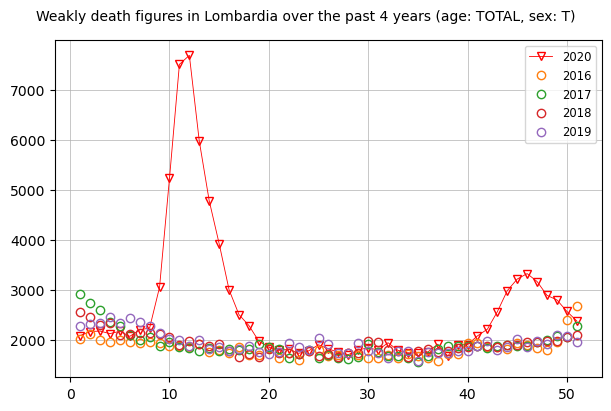

In [29]:
def plot_oneversus(df, index = None, one = None, versus = None,  
                   fig=None, ax=None, shp = (1,1), dpi=_DPI_,
                   xlabel='', ylabel='', title = '', xrottick = False, legend = None,                 
                   grid = False, suptitle = '', locator = None, formatter = None):    
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input timeseries')
    if ax is None:
        if shp in (None,[],()): shp = (1,1)
        if dpi is None:     fig, pax = mplt.subplots(*shp, constrained_layout=True)
        else:               fig, pax = mplt.subplots(*shp, dpi=dpi, constrained_layout=True)
        if isinstance(pax,np.ndarray):
            if pax.ndim == 1:    ax_ = pax[0]
            else:               ax_ = pax[0,0]
        else:
            ax_ = pax
    else:
        ax_, pax = ax, None
    if index is None:
        index = df.index
    if one is not None:
        ax_.plot(df.loc[index,one], ls='-', lw=0.6, c='r', 
                 marker='v', markersize=6, fillstyle='none')
        next(ax_._get_lines.prop_cycler)
    if versus is None:
        versus = df.columns
        try:    versus.remote(one)
        except: pass
    ax_.plot(df.loc[index,versus], ls='None', marker='o', fillstyle='none')
    ax_.set_xlabel(xlabel), ax_.set_ylabel(ylabel)
    if grid is not False:       ax_.grid(linewidth=grid)
    if xrottick is not False:   ax_.tick_params(axis ='x', labelrotation=xrottick)
    if locator is not None:     ax_.xaxis.set_major_locator(locator)
    if formatter is not None:   ax_.xaxis.set_major_formatter(formatter)
    if legend is None:
        legend = [one]
        legend.extend(versus)
    ax_.legend(legend, fontsize='small')
    if title not in ('',None):  ax_.set_title(title,  fontsize='medium')
    if suptitle not in ('',None):       
        fig.suptitle(suptitle,  fontsize='medium')
    if pax is not None:
        return fig, pax
    
plot_oneversus(ts, index = WEEKS, one = YEND, versus = CYEARS, dpi = 100, grid = 0.5,
               suptitle="Weakly death figures in %s over the past %s years (age: %s, sex: %s)" 
                       % (REG_NAME, max(RYEARS)-min(RYEARS), AGE, SEX)
              )

## Excessive deaths representation<a id="death-representation"></a>

Let's further select an extended period of interest (`WEEKRES` as a list of weeks index):

(<Figure size 600x400 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1355bfe90>)

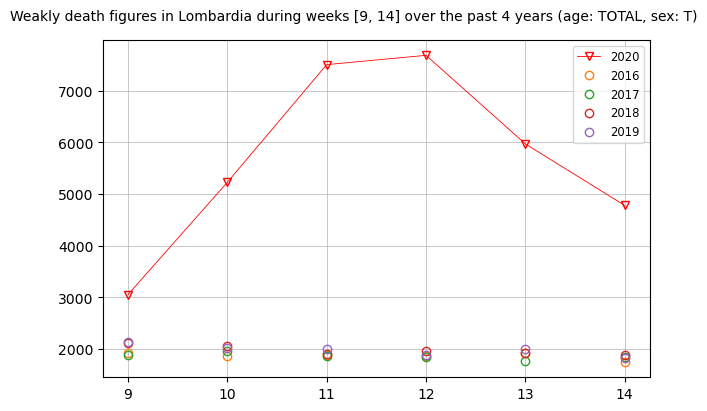

In [30]:
DATERES, WEEKRES = None, list(range(10,14)) # select what you are interested

if WEEKRES is None:
    try:
        WEEKRES = DATERES.isocalendar()[1]
    except:
        WEEKRES = [15]
        
weekview = range(min(WEEKRES)-1, max(WEEKRES)+2)
plot_oneversus(ts, index = weekview, one = YEND, versus = CYEARS, dpi = 100, grid = 0.5,
               suptitle="Weakly death figures in %s during weeks [%s, %s] over the past %s years (age: %s, sex: %s)" 
                       % (REG_NAME, min(weekview), max(weekview), max(RYEARS)-min(RYEARS), AGE, SEX)
              )

The method `estimate_excess_mortality` implements the estimation of both the excess rate and indice of deaths that occured during the selected period (`WEEKRES`) of the end year (`YEND`). It is expressed as:
Considering the base reference $D_{\text{base}}$ taken as the mean (`BASE`, although $\max$ or $\min$ could also be used) of deaths calculated over the previous years (from `YSTART` to `YEND` excluded), the method returns:
* either $r = \frac{D - D_{\text{base}}}{D_{\text{base}}}$ when `INDICE = "RATE"`,
* or $I = 100\times\frac{D}{D_{\text{base}}}$  when `INDICE = "I100"`,

where we obviously verify: $r = \frac{I - 100}{100}$

The output death excess indice/rate is stored in the `INC` column of the output dataset (`w_death_data`):

In [31]:
INDICE = 'I100' # 'RATE'

def estimate_excess_mortality(indice, df, inc = "rinc", agg = "mean", week=1, ystart=2015, year=2020):
    try:
        assert isinstance(indice,str) and indice in ('I100', 'RATE')
    except:
        raise IOError('wrong indice flag')
    try:
        assert isinstance(df,(pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    if np.isscalar(week): 
        week = [week,]
    col_drop = [col for col in death_data.columns 
                if re.search('W',col) is not None and int(col.split('W')[1]) not in week]
    data = df.drop(columns = col_drop)
    years = range(ystart, year)
    cols = [col for col in df.columns                               \
            if any([col.strip().endswith('W%02d' % w) for w in week]) \
            and int(col.split('W')[0]) in years]
    sagg = df[cols].agg(agg, axis='columns', skipna=False) # we cant ignore missing values!
    if len(week)>1:
        cols = [col for col in df.columns                               \
                if any([col.strip().endswith('W%02d' % w) for w in week]) \
                and col.startswith('%sW' % str(year))]
        syear = df[cols].mean(axis='columns', skipna=False) # take the mean 
    else:
        syear = df['%sW%02d' % (str(year),week[0])]
    if indice == 'RATE':
        data[inc] = 100 * syear.sub(sagg).div(sagg) # we still mulitply by 100...
    elif indice == 'I100':
        data[inc] = 100 * syear.div(sagg)            
    return data

BASE = "mean" # "max" # "min"
INC = 'rinc'
w_death_data = estimate_excess_mortality(INDICE, death_data, inc = INC, agg = BASE, 
                                         week = WEEKRES, ystart = YSTART, year = YEND)

w_death_data.head()

2020W13  2020W12  2020W11  2020W10  2019W13  2019W12  2019W11  2019W10  \
0    218.0    197.0    201.0    227.0    199.0    200.0    199.0    232.0   
1     35.0     71.0    243.0    109.0    199.0    200.0    199.0    232.0   
2     24.0      1.0      7.0      2.0     64.0     57.0     60.0     61.0   
3     11.0      8.0      6.0     18.0     12.0     16.0      8.0      6.0   
4     21.0     14.0     19.0     18.0     21.0     17.0     23.0     16.0   

   2018W13  2018W12  ...  2017W10  2016W13  2016W12  2016W11  2016W10  unit  \
0    190.0    225.0  ...    197.0    180.0    219.0    184.0    175.0    NR   
1    190.0    225.0  ...    196.0    180.0    219.0    184.0    175.0    NR   
2     61.0     62.0  ...     55.0     65.0     64.0     51.0     47.0    NR   
3      6.0     14.0  ...     11.0     15.0      8.0      8.0      3.0    NR   
4     17.0     22.0  ...     16.0     22.0     21.0     18.0     15.0    NR   

   sex    age    geo        rinc  
0    F  TOTAL     AL  104.041962  
1    F  TOTAL    AL0   56.560667  
2    F  TOTAL   AL01   14.107884  
3    F  TOTAL  AL011  113.157895  
4    F  TOTAL  AL012   93.203883  

[5 rows x 25 columns]

Let's generate (using the method `build_table`) the statistics for the entire population during the specific period (`s_death_data`):

In [32]:
def build_table(df, inc = 'rinc', key='NUTS_ID', age = "TOTAL", sex = "T", miss_id = {}):
    try:
        assert isinstance(df, (pd.Series,pd.DataFrame))
    except:
        raise IOError('wrong format for input dataset')
    col_drop = list(set(df.columns).difference(set(['geo',inc])))
    data_miss = pd.DataFrame({key: miss_id[0].copy(), inc: np.nan})
    return pd.concat([(
        df.loc[(df["age"]==age) & (df["sex"]==sex)]
        .copy()
        .drop(columns=col_drop)
        #.dropna(axis='index', subset=[inc])
        .rename(columns={'geo':key})
        ),
        data_miss
        ], 
        axis=0, ignore_index=True
    )

s_death_data = build_table(w_death_data, inc = INC, key=KEY, 
                           age = AGE, sex = SEX, 
                           miss_id=MISSING_CTRY_ID)

s_death_data.head(-10)

NUTS_ID        rinc
0         AL  102.152080
1        AL0   36.144232
2       AL01    1.751825
3      AL011   92.993631
4      AL012   93.682589
...      ...         ...
1415    UKN0   93.317702
1416   UKN06   99.488229
1417   UKN07   75.653924
1418   UKN08   85.106383
1419   UKN09   88.627451

[1420 rows x 2 columns]

We assume completeness here, that is when an administrative unit $A$ is available at level $l$, all other units belonging to the same region than $A$ at previous level $l-1$ are also available at level $l$. We merge the information from both datasets `nuts_data` (where geometries are stored) and `s_death_data` (where excess death `INC` is calculated) into a single dataset `nuts_death_data`:

In [33]:
def build_unit_level(nuts, death, levels = [0, 1, 2, 3], key='NUTS_ID', how='inner'): 
    try:
        assert (isinstance(nuts, dict) 
                and all([isinstance(df,(gpd.GeoSeries, gpd.GeoDataFrame)) for df in nuts.values()])
                and set(nuts.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    data = dict.fromkeys(levels)
    for l in levels:
        temp = (nuts[l]
                .merge(death, on=key, how=how)
                #.dropna(axis='index', subset=[inc]) 
               )
        temp = temp[~(temp.geometry.is_empty | temp.geometry.isna())]
        temp.geometry = temp.geometry.buffer(0) # deal with invalid geometry
        data.update({l: temp})
    return data

nuts_death_data = build_unit_level(nuts_data, s_death_data, 
                                   levels = LEVELS, key = KEY, how='right') 

nuts_death_data[3].head()

id NUTS_ID  LEVL_CODE CNTR_CODE         NAME_LATN        NUTS_NAME  \
0  BG341   BG341        3.0        BG            Burgas           Бургас   
1  BG342   BG342        3.0        BG            Sliven           Сливен   
2  BG343   BG343        3.0        BG            Yambol            Ямбол   
3  BG344   BG344        3.0        BG      Stara Zagora     Стара Загора   
4  BG411   BG411        3.0        BG  Sofia (stolitsa)  София (столица)   

   MOUNT_TYPE  URBN_TYPE  COAST_TYPE    FID  \
0         4.0        2.0         1.0  BG341   
1         2.0        2.0         3.0  BG342   
2         4.0        2.0         3.0  BG343   
3         2.0        2.0         3.0  BG344   
4         3.0        1.0         3.0  BG411   

                                            geometry       rinc  
0  POLYGON ((27.88262 42.83841, 27.86476 42.72294...  95.449501  
1  POLYGON ((26.57773 42.98570, 26.58999 42.92012...  81.222707  
2  POLYGON ((27.05965 42.08834, 26.98168 42.01729...  97.126437  
3  POLYGON ((25.83749 42.77723, 25.86882 42.63238...  89.155183  
4  POLYGON ((23.29019 42.53271, 23.16082 42.63238...  99.024390

However, we know that some countries are represented at higher level only (this also includes those small countries which do not have NUTS representation in the highest level, say Luxembourg for instance). In practice, we transfer (in the method `build_unit_level`) the information available about an administrative unit $A$ at level $l$ to the highest $l+1$. In doing so, we shall also pay special attention to the list of countries for which data are not available in the specific period considered here besides the missing ones, *i.e.* those not listed in the table (update of `nuts_death_data`):

In [34]:
def propagate_unit_level(data, levels = [0, 1, 2, 3], inc = 'rinc', key = 'NUTS_ID', miss_id = {}):
    try:
        assert (isinstance(data, dict) 
                and all([isinstance(df,(gpd.GeoSeries, gpd.GeoDataFrame)) for df in data.values()])
                and set(data.keys()).difference(set(levels)) == set())
    except:
        raise IOError('wrong format for input data dictionary')
    nan_ctry_id = copy.deepcopy(miss_id) or dict.fromkeys(levels) 
    for l in range(len(levels)):
        level = levels[l]
        nan_ctry_id[l].extend([_id[:2] 
                               for _id in data[level].loc[data[level][inc].isnull(), key].unique().tolist() 
                               if len(_id)==l+2])
        nan_ctry_id[l] = list(set(nan_ctry_id[l]))
    for ctry in nan_ctry_id[0]:
        level0 = levels[0]
        data_miss = data[level0][data[level0][key].str.startswith(ctry)].copy()
        data_miss.geometry = data_miss.geometry.buffer(0)
        for level in levels[1:]:
            data[level] = pd.concat([data[level].loc[~(data[level][key].str.startswith(ctry))], 
                                     data_miss
                                    ], 
                                    axis=0, ignore_index=True
                                   )
    for l in range(1,len(levels)):
        for ctry in nan_ctry_id[l]:
            if ctry in nan_ctry_id[l-1]:
                continue
            levelp = levels[l-1]
            data_miss = data[levelp].loc[data[levelp][key].str.startswith(ctry)].copy()
            data_miss.geometry = data_miss.geometry.buffer(0)
            for l_ in range(l,len(levels)):
                level_ = levels[l_]
                data[level_] = pd.concat([data[level_].loc[~(data[level_][key].str.startswith(ctry))], 
                                          data_miss 
                                         ], 
                                         axis=0, ignore_index=True
                                        )
    return data

nuts_death_data = propagate_unit_level(nuts_death_data, miss_id = MISSING_CTRY_ID,
                                       levels = LEVELS, inc = INC, key = KEY)
nuts_death_data[3].head(5)

id NUTS_ID  LEVL_CODE CNTR_CODE         NAME_LATN        NUTS_NAME  \
0  BG341   BG341        3.0        BG            Burgas           Бургас   
1  BG342   BG342        3.0        BG            Sliven           Сливен   
2  BG343   BG343        3.0        BG            Yambol            Ямбол   
3  BG344   BG344        3.0        BG      Stara Zagora     Стара Загора   
4  BG411   BG411        3.0        BG  Sofia (stolitsa)  София (столица)   

   MOUNT_TYPE URBN_TYPE COAST_TYPE    FID  \
0         4.0         2          1  BG341   
1         2.0         2          3  BG342   
2         4.0         2          3  BG343   
3         2.0         2          3  BG344   
4         3.0         1          3  BG411   

                                            geometry       rinc  
0  POLYGON ((27.88262 42.83841, 27.86476 42.72294...  95.449501  
1  POLYGON ((26.57773 42.98570, 26.58999 42.92012...  81.222707  
2  POLYGON ((27.05965 42.08834, 26.98168 42.01729...  97.126437  
3  POLYGON ((25.83749 42.77723, 25.86882 42.63238...  89.155183  
4  POLYGON ((23.29019 42.53271, 23.16082 42.63238...  99.024390

For display reason, we define a very coarse bounding box (`EUclip`, see for instance [this visualisation](http://bboxfinder.com/#30.200000,-25.200000,71.300000,45.300000)) that is embedded in the NUTS bounding box (`NUTSarea`) so as to render the data in a smaller region: 

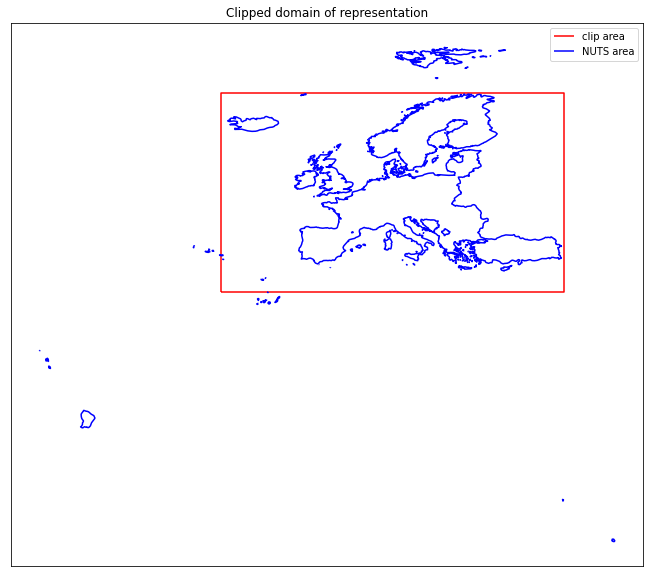

In [35]:
EUmask = geometry.Polygon([#w: -25.5, s:35, e:30.2, n:71.3 in EPSG:4326 system
                         (-25.5, 30.2),
                         (45.3,  30.2),
                         (45.3,  71.3),
                         (-25.5, 71.3)
])
EUclip = gpd.GeoDataFrame(index=[0], geometry=[EUmask], crs=PROJ)

NUTSarea = gpd.GeoDataFrame(index=[0], geometry=[nuts_data[0].unary_union], crs=PROJ)


f, ax = mplt.subplots(1, figsize=(16, 10))
EUclip.boundary.plot(ax=ax, color='r', label='clip area')
NUTSarea.boundary.plot(ax=ax, color='b', label='NUTS area')
ax.axes.get_xaxis().set_visible(False); ax.axes.get_yaxis().set_visible(False)
ax.set_title('Clipped domain of representation')
ax.legend()
mplt.show()

Following, we use the clip area to crop and represent (on a continuous scale) the results available on continental Europe only (`crop`) distributed at NUTS level `LEVEL`. Missing countries are also represented:<a id='MapAggregated'></a>

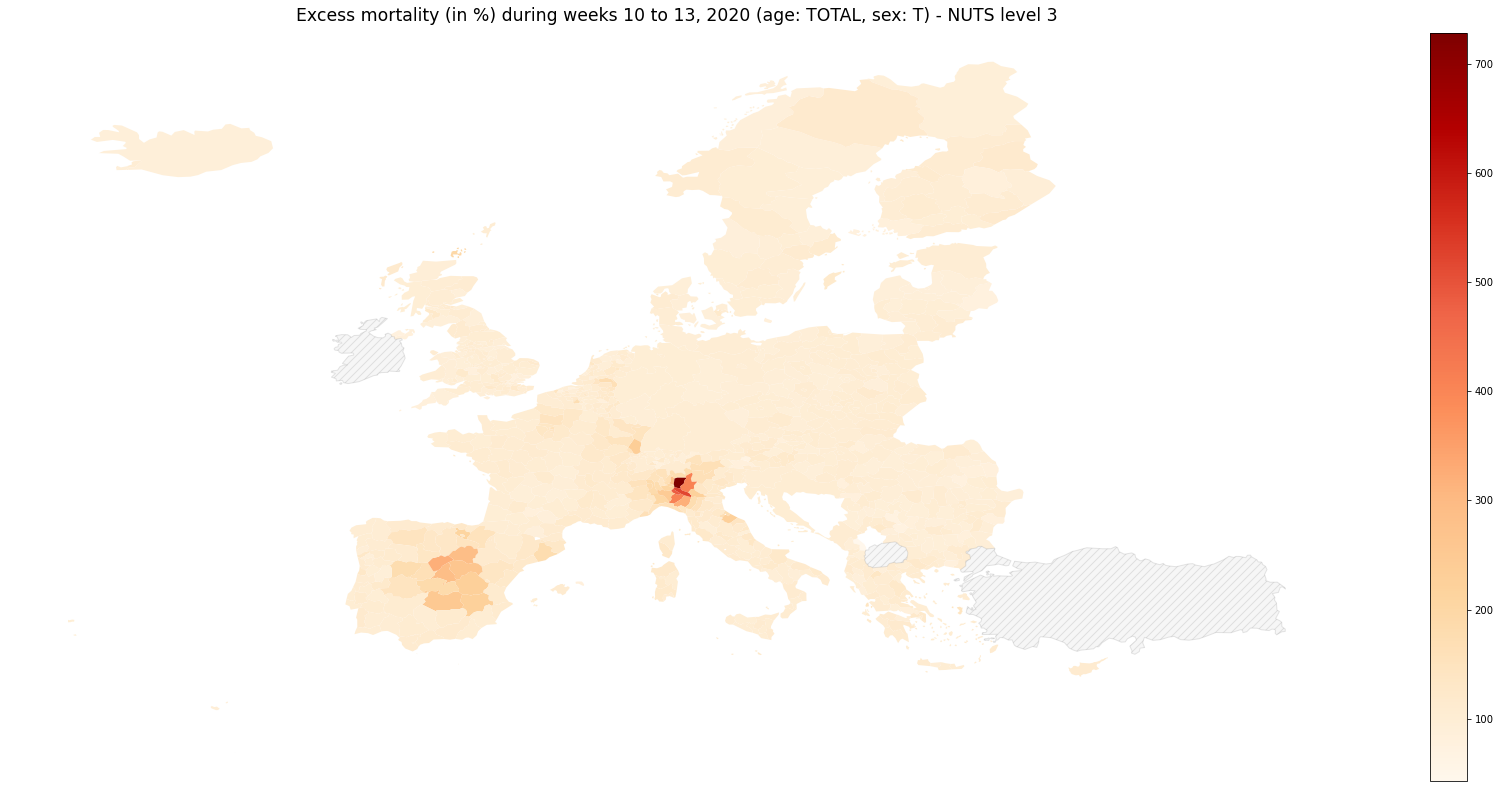

In [36]:
LEVEL = 3
crop = gpd.clip(nuts_death_data[LEVEL], EUclip)
# crop = nuts_death_data[LEVEL].intersection(EUclip.unary_union) 

f, ax = mplt.subplots(1, figsize=(30, 25))
crop.plot(column = 'rinc', ax = ax, cmap = 'OrRd', legend = True,
          legend_kwds = {'shrink':0.55},
          missing_kwds = { "color": "lightgrey", "alpha": 0.2, "edgecolor": "grey", "hatch": "///"}
         )
ax.set_axis_off()
ax.set_title('Excess mortality (in %%) during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
             % (min(WEEKRES), max(WEEKRES), YEND, AGE, SEX, LEVEL), size = 'xx-large')
# f.tight_layout()
#f.subplots_adjust(hspace=0,wspace=-1)
mplt.show()

For information, the NUTS data (at various levels, depending on the countries' availability at the selected representation level `LEVEL`) represented in the map above are listed in `INREGIONS`:

In [37]:
INREGIONS = s_death_data['NUTS_ID'].unique().tolist()

print("NUTS regions actually available for this selection: \033[1m%s\033[0m" % INREGIONS)

NUTS regions actually available for this selection: ['AL', 'AL0', 'AL01', 'AL011', 'AL012', 'AL013', 'AL014', 'AL015', 'AL02', 'AL021', 'AL022', 'AL03', 'AL031', 'AL032', 'AL033', 'AL034', 'AL035', 'ALX', 'ALXX', 'ALXXX', 'AT', 'AT1', 'AT11', 'AT111', 'AT112', 'AT113', 'AT12', 'AT121', 'AT122', 'AT123', 'AT124', 'AT125', 'AT126', 'AT127', 'AT13', 'AT130', 'AT2', 'AT21', 'AT211', 'AT212', 'AT213', 'AT22', 'AT221', 'AT222', 'AT223', 'AT224', 'AT225', 'AT226', 'AT3', 'AT31', 'AT311', 'AT312', 'AT313', 'AT314', 'AT315', 'AT32', 'AT321', 'AT322', 'AT323', 'AT33', 'AT331', 'AT332', 'AT333', 'AT334', 'AT335', 'AT34', 'AT341', 'AT342', 'BE', 'BE1', 'BE10', 'BE100', 'BE2', 'BE21', 'BE211', 'BE212', 'BE213', 'BE22', 'BE221', 'BE222', 'BE223', 'BE224', 'BE225', 'BE23', 'BE231', 'BE232', 'BE233', 'BE234', 'BE235', 'BE236', 'BE24', 'BE241', 'BE242', 'BE25', 'BE251', 'BE252', 'BE253', 'BE254', 'BE255', 'BE256', 'BE257', 'BE258', 'BE3', 'BE31', 'BE310', 'BE32', 'BE321', 'BE322', 'BE323', 'BE324', 'BE

## Spatio-temporal visualisations<a id="spatial-visualisations"></a>

Likewise the *Statistics Explained* article on [death statistics](https://ec.europa.eu/eurostat/statistics-explained/index.php?title=Weekly_death_statistics&stable), we actually the death excess on a weekly basis. The reference shall still be taken as the mean over the previous years starting from 201. For reminder: 

In [38]:
PROJ = 'EPSG:4326'
INDICE = 'I100'
BASE = "mean" # "max" # "min"
INC = 'rinc'
AGE, SEX = "TOTAL", "T"
YSTART, YEND = 2016, 2020 # YCUR

then we use the previously defined functions to generate the desired datasets (`data`), once per single week (`WEEKRES`) and per single NUTS level (`LEVELS`):

In [39]:
data = dict.fromkeys(WEEKRES)

for w in WEEKRES:
    temp = estimate_excess_mortality(INDICE, death_data, inc = INC, agg = BASE, 
                                     week = w, ystart = YSTART, year = YEND)
    temp = build_table(temp, inc = INC, key=KEY,
                       age = AGE, sex = SEX, 
                       miss_id = MISSING_CTRY_ID)
    temp = build_unit_level(nuts_data, temp, 
                            levels = LEVELS, key = KEY, how='right') 
    data[w] = propagate_unit_level(temp, levels = LEVELS, 
                                   inc = INC, key = KEY, 
                                   miss_id = MISSING_CTRY_ID)

We display the different estimations together:<a id='Maps'></a> 

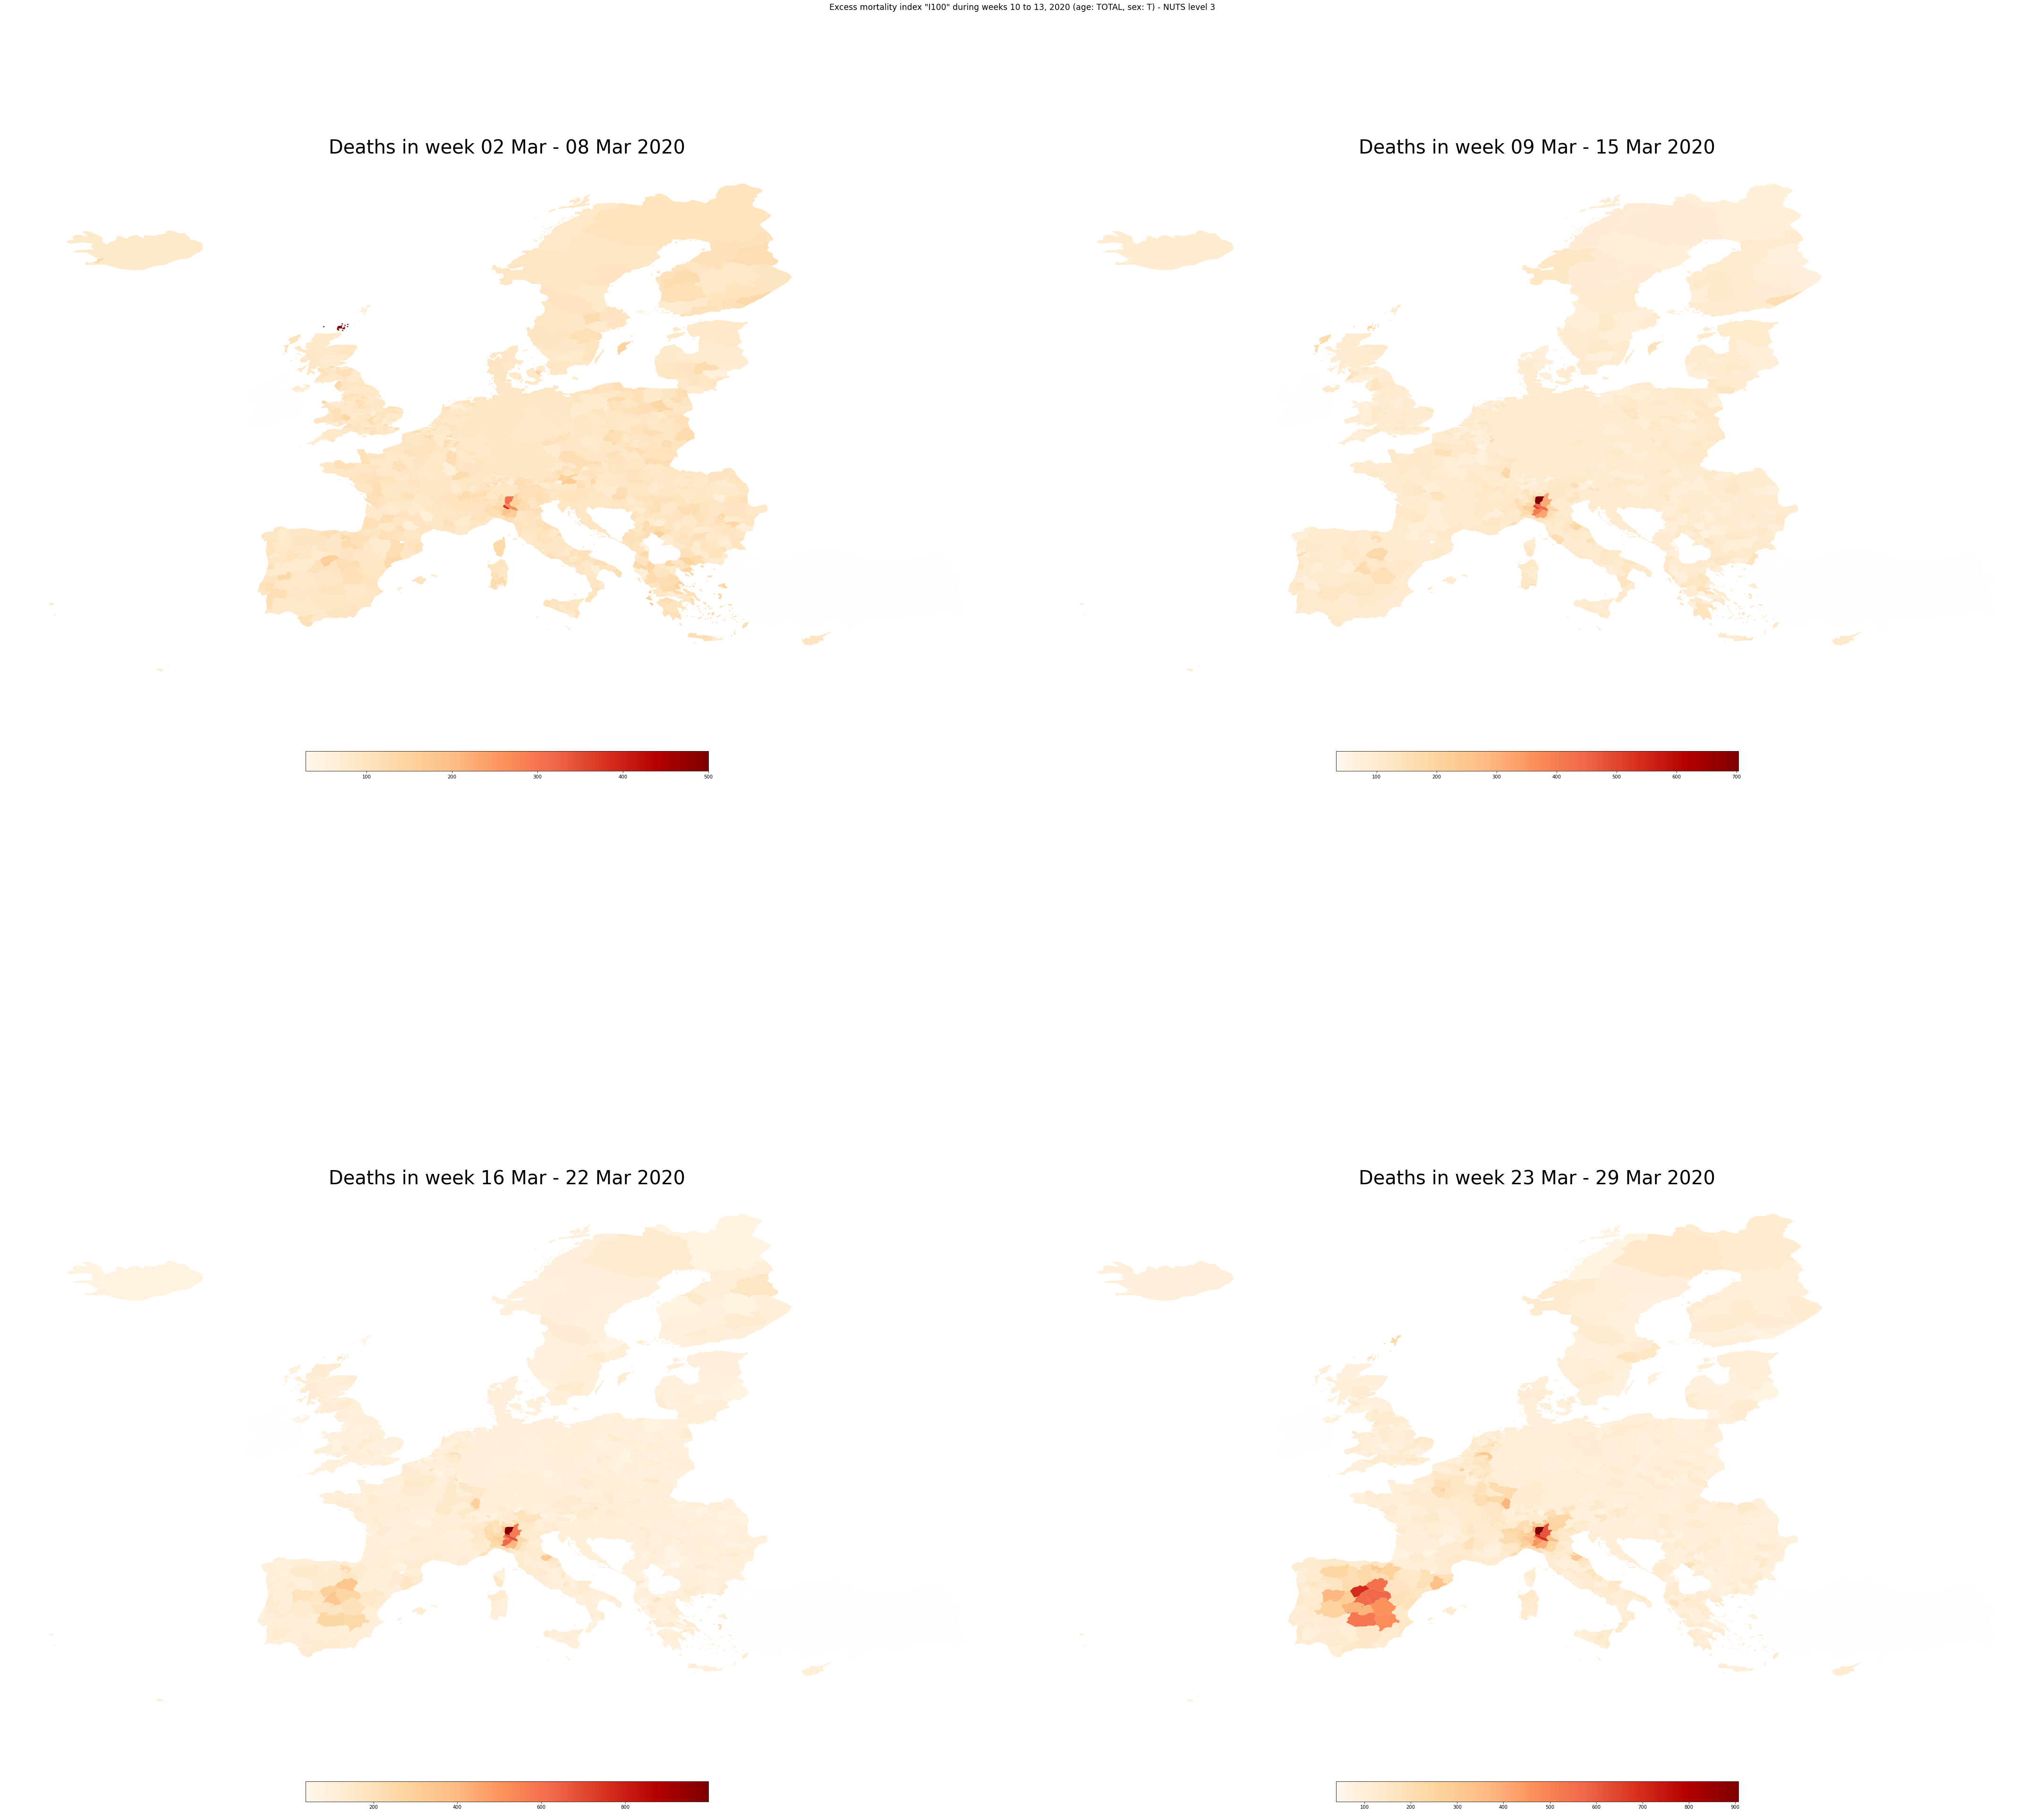

In [40]:
LEVEL = 3

ncols, height = 2, 60 # 45
nrows = int(np.ceil(len(WEEKRES) / ncols))
f, fx = mplt.subplots(nrows, ncols, constrained_layout = True,
                      figsize = (int(height*ncols/nrows), height))
nax = nrows * ncols

for i, w in enumerate(WEEKRES):
    x, y = int(i/ncols), i%ncols
    _ax = fx[x] if ncols == 1 else fx[x][y]
    crop = gpd.clip( data[w][LEVEL], EUclip)
    crop.plot(column = INC, ax = _ax, cmap = 'OrRd', legend = True,
              legend_kwds = {'shrink':0.4, 'orientation': 'horizontal'},
              missing_kwds = { "color": "lightgrey", "alpha": 0.02, "edgecolor": "grey", "hatch": "///"}
             )
    day = '%s-W%s' % (YEND, w)
    mon, sun = [datetime.strptime(day + '-%s' % d, '%G-W%V-%u').strftime("%d %b") for d in [1,7]]
    _ax.set_axis_off()
    _ax.set_title('Deaths in week %s - %s %s' % (mon, sun, YEND), fontsize=40) 

for j in range(i+1, nax):
    x, y = int(j/ncols), j%ncols
    _ax = fx[x] if ncols == 1 else fx[x][y]
    _ax.set_axis_off()
    _ax.axes.get_xaxis().set_visible(False); _ax.axes.get_yaxis().set_visible(False)

y_title_pos = (fx[0] if ncols == 1 else fx[0][0]).get_position().get_points()[1][1]+(1/nrows)*0.15

suptitle = ('Excess mortality %s during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
            % ('index "I100"' if INDICE=='I100' else 'rate', min(WEEKRES), max(WEEKRES), YEND, AGE, SEX, LEVEL)
           )

f.suptitle(suptitle, y=y_title_pos, fontsize='xx-large')
mplt.show()

Note that in the visualisations above, the colormap used to render the maps differs from one visualisation to the other, hence making comparison difficult. 

Let's now represent these data "all together". We first build a colormap based on the actual values and whose color values follow the color code adopted in the *Statistics Explained* article:

In [41]:
colors = ((238,208,183), (227,168,127), (219,131,83), (211,98,42), (182,0,0))
colors_index = [nuts_death_data[LEVEL][INC].min(), 100, 200, 300, 400]
vmin = min([int(np.floor(data[w][LEVEL][INC].min())) for w in WEEKRES])
vmax = max([int(np.floor(data[w][LEVEL][INC].max())) for w in WEEKRES])

cmap_nuts = bcm.StepColormap(colors=colors,index=colors_index,
                            vmin=vmin, vmax=vmax,
                            caption='Death excess index "I100"' if INDICE=='I100' else 'Death excess rate'
                           )

cmap_nuts

We will use GISCO tiling services as the background tile:

In [42]:
PROJ_ = PROJ.replace(':','')

GISCO_TILES = { 
    'OSM@EC':
    {'url': 'http://gisco-services.ec.europa.eu/maps/tiles/OSMCartoBackground/%s/{z}/{x}/{y}.png' % PROJ_,
     'attr': '@OpenStreetMap contributors'
    },
    'OSM@EC Compo':
    {'url': 'http://gisco-services.ec.europa.eu/maps/tiles/OSMCartoComposite/%s/{z}/{x}/{y}.png' % PROJ_,
     'attr': '@OpenStreetMap contributors'
    },
    'OSM@EC V4':
    {'url': 'http://gisco-services.ec.europa.eu/maps/tiles/OSMCartoV4Background/%s/{z}/{x}/{y}.png' % PROJ_,
     'attr': '@OpenStreetMap contributors'
    },
    'Blue Marble':
    {'url': 'http://gisco-services.ec.europa.eu/maps/tiles/BlueMarble/%s/{z}/{x}/{y}.png' % PROJ_,
     'attr': '@NASA Earth Observatory'
    },
    'Grey Earth':
    {'url': 'http://gisco-services.ec.europa.eu/maps/tiles/GreyEarth/%s/{z}/{x}/{y}.png' % PROJ_,
     'attr': '@Natural Earth'
    }
}

[GISCO_TILES[k].update({'name': k}) for k in GISCO_TILES.keys()] and None # to avoid printing out

and actually the updated OSM:

In [43]:
TILING = GISCO_TILES['OSM@EC V4'] # ['Grey Earth'] 

EUCENTRE = (50.03, 10.35)
MAPCENTRE = (44, 10.35) # EUCENTRE
MAPZOOM = 4

Following, we can represent the choropleths (with this common colormap) for the different weeks:<a id='MapsOverlay'></a> 

In [44]:
m = folium.Map(MAPCENTRE, zoom_start=MAPZOOM,
               tiles=None,
               # width = '100%', height = '100%',
               width = 1000, height = 1000,
               crs = PROJ_)

folium.TileLayer(TILING['url'], 
                 attr = TILING['attr'], 
                 name = TILING['name']
                ).add_to(m)

def style_function(d_rinc, feature):
    _id = d_rinc.get(feature['properties'][KEY],None)
    return {
        'color':'black',
        'fillColor': '#808080', # '#gray'
        'fillOpacity': 0.1,
        'weight': 0.1,
    } if (_id is None or np.isnan(_id)) else {
        'color':'black',
        'fillColor': cmap_nuts(_id),
        'fillOpacity': 0.9,
        'weight': 0.3,
    } 

def highlight_function(feature):
    return {'fillColor': '#000000', 
            'color':'#000000',
            'fillOpacity': 0.6, 
            'weight': 0.1}

def tooltip():
    return folium.GeoJsonTooltip(fields=[KEY,INC],
            aliases=['NUTS', 'Index "I100"' if INDICE=='I100' else 'Rate (%)'],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;"),
            sticky=True
        )

for i, w in enumerate(WEEKRES):
    day = '%s-W%s' % (YEND, w)
    mon, sun = [datetime.strptime(day + '-%s' % d, '%G-W%V-%u').strftime("%d %b") for d in [1,7]]
    inc_dict = data[w][LEVEL].set_index(KEY)[INC].to_dict()
    folium.GeoJson(
        data = data[w][LEVEL].to_json(),
        name = '%s - %s (#%s)' % (mon, sun, w),
        style_function = functools.partial(style_function, inc_dict),
        highlight_function = highlight_function,
        tooltip = tooltip(),
        show = True if i==0 else False
    ).add_to(m)

folium.LayerControl('topleft', collapsed=False).add_to(m)
cmap_nuts.add_to(m)

m

We can also use the `TimeSliderChoropleth` class of `folium` to represent dynamically the temporal evolution of the death excess rate:<a id='MapsSlider'></a> 

In [45]:
# building a color field
for i, w in enumerate(WEEKRES):
    # inc_dict = data[w][LEVEL].set_index(KEY)[INC].to_dict()
    # data[w][LEVEL]['color'] = (data[w][LEVEL][KEY]).apply(lambda x: cmap_nuts(inc_dict.get(x,None)))
    data[w][LEVEL]['color'] = (data[w][LEVEL][INC]
                               .apply(lambda x: cmap_nuts(x) if ~np.isnan(x) else '#808080')
                              )
    
# value we will iterate in order to create the styledict
dayfirst = datetime.strptime('%s-W%s-1' % (YEND, WEEKRES[0]), '%G-W%V-%u') #.strftime("%d %b")
dates = (pd.date_range(dayfirst, periods=len(WEEKRES), freq='W').astype(int) // 10**9).astype('U10')
# dates = [datetime.strptime('%s-W%s-1' % (YEND, w), '%G-W%V-%u') for w in WEEKRES]
nuts_ids = nuts_death_data[LEVEL][KEY].unique().tolist()

# styledict contains for each NUTS ID the timestamp (=week index) and the color to plot
styledict = dict.fromkeys(nuts_ids)

# iterate to populate the styledict: not the most efficient though...
for _id in nuts_ids:
    styledict[_id] = {}
    for i, w in enumerate(WEEKRES):
        dcol = data[w][LEVEL].loc[data[w][LEVEL][KEY] == _id, 'color'] 
        if dcol.empty: continue
        color = dcol.iloc[0]
        styledict[_id].update({dates[i]: 
                               {'color': color,
                                'opacity': 0.1 if color == '#808080' else 0.9}
                              })

We then create and render the map:

In [49]:
m = folium.Map(EUCENTRE, zoom_start=MAPZOOM-1,
               tiles = None,
               # width = 1000, height = 1000,
               crs = PROJ_)

folium.TileLayer(TILING['url'], 
                 attr = TILING['attr'], 
                 name = TILING['name']
                ).add_to(m)


foliump.TimeSliderChoropleth(
    #data[WEEKRES[0]][LEVEL].set_index(KEY).to_json(),
    nuts_death_data[LEVEL].set_index(KEY).to_json(), # file with all geometries 
    styledict = styledict
).add_to(m)

cmap_nuts.add_to(m)

m

### Annex - Other possible representations

Using instead the `Choropleth` class to represent the aggregated period in `nuts_death_data`:

In [47]:
LEVEL = 3
TILING = GISCO_TILES['Grey Earth']

m = folium.Map(MAPCENTRE, zoom_start=MAPZOOM,
               tiles=None,
               #width = 1000, height = 1000,
               crs = PROJ_)

folium.TileLayer(TILING['url'], 
                 attr = TILING['attr'], 
                 name = TILING['name']
                ).add_to(m)

dayfirst = datetime.strptime('%s-W%s-1' % (YEND, WEEKRES[0]), '%G-W%V-%u').strftime("%d %b")
daylast = datetime.strptime('%s-W%s-7' % (YEND, WEEKRES[-1]), '%G-W%V-%u').strftime("%d %b") 

legend_name = ('Excess death %s: Period %s - %s %s' 
               % ('index "I100"' if INDICE=='I100' else 'rate', dayfirst, daylast, YEND))

choro = folium.Choropleth(
    name = 'Period %s - %s %s' % (dayfirst, daylast, YEND),
    legend_name = legend_name,
    geo_data = nuts_death_data[LEVEL].to_json(), 
    data = nuts_death_data[LEVEL],
    columns=[KEY, INC],
    fill_color='OrRd',
    fill_opacity = 0.9, 
    line_opacity = 0.9,
    nan_fill_color='grey',
    nan_fill_opacity=0.05,
    nan_line_opacity = 0.05,
    key_on='feature.properties.NUTS_ID',
    show=True
).add_to(m)


#folium.LayerControl(collapsed=False).add_to(m)
m

Say that the package `ipyleaflet` is available, you could also display the `nuts_death_data` values:

In [48]:
import ipyleaflet

LEVEL = 3

geo_data = json.loads(nuts_death_data[LEVEL]
                      .dropna(axis='index', subset=[INC]) 
                      .to_json()
                     )
choro_data = dict(zip(nuts_death_data[LEVEL].index.astype(str).tolist(), 
                      nuts_death_data[LEVEL][INC]))

m = ipyleaflet.Map(center = MAPCENTRE, zoom=MAPZOOM)

layer = ipyleaflet.Choropleth(
    geo_data = geo_data,
    choro_data = choro_data,
    colormap = cmap_nuts,
    on_key = 'id',
    style = {'fillOpacity': 1, 'dashArray': '5, 5'},
    name = 'Excess mortality during weeks %s to %s, %s (age: %s, sex: %s) - NUTS level %s' 
             % (min(WEEKRES), max(WEEKRES), YEND, AGE, SEX, LEVEL)
)

m.add_layer(layer)

m

Map(center=[44, 10.35], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…